# SPICY Tutorial 2
This is the second tutorial exercise which deals with the regression of a scalar quantity. In this case, we use it for the two velocity components of an Oseen vortex. 

We start by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from spicy_class_2103 import spicy 

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

We define our domain boundaries and generate our synthetic data points. The data is sampled in $(x,y) = [-0.5,0.5]\times[-0.5,0.5]$.

The vortex is expressed as $u_r = 0$ and $u_\theta = \Gamma/2 \pi r \left( 1- e ^{-r^2/c_\theta}\right)$.

Here, $c_\theta = r_c^2 / \gamma$, with $r_c = 0.1$ the radial distance of maximum velocity, $\gamma = 1.25643$ and $\Gamma = 10$ the dimensionless circulation.

In [2]:
# Fix the random seed to ensure reproducibility
np.random.seed(42)

# Number of particles
n_p = 5000

# Define the domain boundaries and flow properties
x1_hat, x2_hat = -0.5, 0.5 # m, m
y1_hat, y2_hat = -0.5, 0.5 # m, m
rho = 1 # kg/m^3
mu = 0 # Pa s

# Generate the random points
X = np.random.random(n_p)*(x2_hat - x1_hat) + x1_hat
Y = np.random.random(n_p)*(y2_hat - y1_hat) + y1_hat

# Compute the radius and angle in the 2D domain
r = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)

# Hyperparameters of the vortex
Gamma = 10
r_c = 0.1
gamma = 1.256431
c_theta = r_c**2/gamma

# Compute the velocity field
u_theta = Gamma / (2*np.pi*r) * (1 - np.exp(-r**2 / (r_c**2 / gamma)))
U = np.sin(theta) * u_theta
V = -np.cos(theta) * u_theta 

# Add 10% noise to it
q = 0.1
U_noise = U * (1 + q*np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q*np.random.uniform(-1, 1, size = V.shape))


## Velocity regression

We start with the regression of the velocity field.

#### Step 1: Initialize the SPICY class

In [3]:
SP_vel = spicy([U_noise], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

In [4]:
SP_vel.clustering([6,50], r_mM=[0.05,0.7], eps_l=0.88)

Clustering level 0 completed
Clustering level 1 completed


#### Step 3: Define the boundary conditions
In this case, we do not have any boundary conditions as there are no walls of the domain where we would have zero velocity.

In [5]:
SP_vel.scalar_constraints()

0 Dirichlet conditions assigned
0 Neumann conditions assigned


We can look at the clustering result, the left-hand side shows the RBFs in 2D, the right hand side shows the diameter distribution.

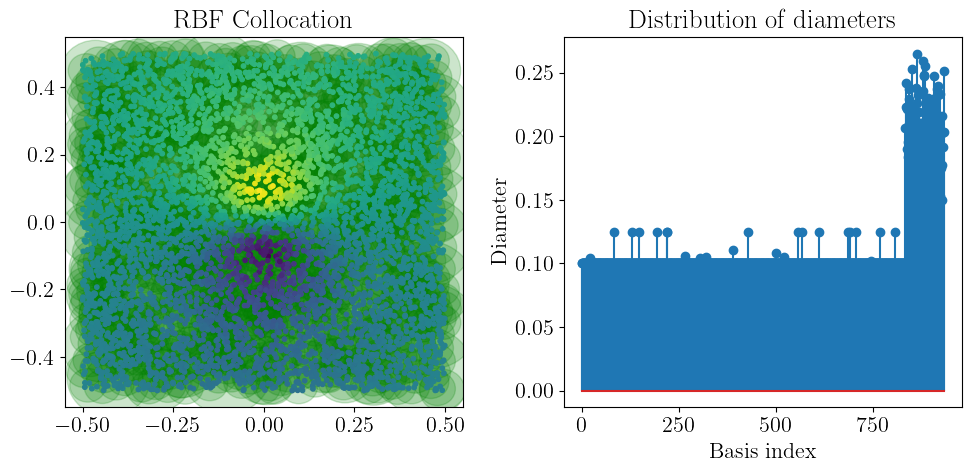

In [6]:
SP_vel.plot_RBFs()

#### Step 4: Assemble the linear system
We assemble the regression, with a penalty for a divergence-free flow

In [7]:
SP_vel.Assembly_Regression()

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [8]:
SP_vel.Solve(K_cond=1e8)

Solving without constriaints
Matrix A regularized


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [9]:
solution_velocity = SP_vel.Get_Sol(grid=[X,Y])
# Extract individual velocity components
U_calc = solution_velocity

We can now compute the error in the magnitude of $u$, which is below 1%.

In [10]:
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
print('Velocity error in  u: {0:.3f}%'.format(error_u*100))

Velocity error in  u: 1.197%


We can also use the same clustering of $u$ to perform the regression for $v$. For this, we are accessing the internal variables of SPICY, i.e. they are overwritten. Of course, it would also be possible to initialize another class and repeat the clustering, but this is shorter.

In [11]:
SP_vel.u = V_noise

The constraints are the same as before and we can directly build the system and solve it.

In [12]:
# Assemble the system
SP_vel.Assembly_Regression()
# Solve it
SP_vel.Solve(K_cond=1e8)
# And obtain the solution of V
solution_velocity = SP_vel.Get_Sol(grid=[X,Y])
# Extract individual velocity components
V_calc = solution_velocity
# Compute the error and print it
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)
print('Velocity erro in v: {0:.3f}%'.format(error_v*100))

Solving without constriaints
Matrix A regularized
Velocity erro in v: 1.099%


We can now also compute the magnitude of the velocity and its error.

In [13]:
# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)

print('Total velocity error: {0:.3f}%'.format(error_magn*100))

Total velocity error: 0.998%


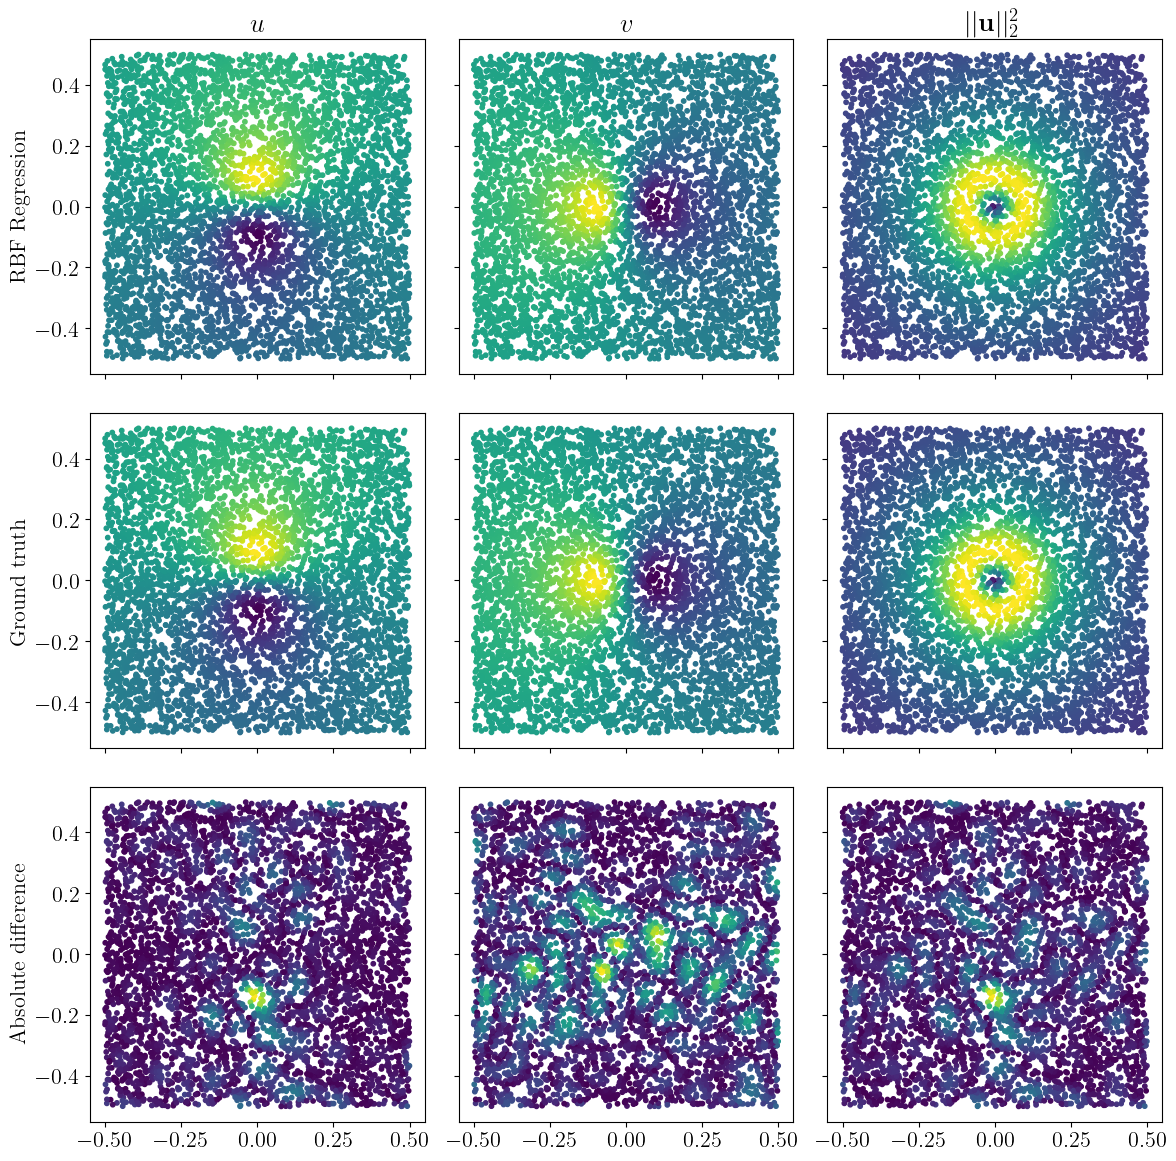

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,12), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X, Y, c=U_calc, s=10)
axes[1,0].scatter(X, Y, c=U, s=10)
axes[2,0].scatter(X, Y, c=np.abs(U_calc-U), s=10) 

axes[0,1].scatter(X, Y, c=V_calc, s=10)
axes[1,1].scatter(X, Y, c=V, s=10)
axes[2,1].scatter(X, Y, c=np.abs(V_calc-V), s=10)  


axes[0,2].scatter(X, Y, c=U_magn_calc, s=10)
axes[1,2].scatter(X, Y, c=U_magn, s=10)
axes[2,2].scatter(X, Y, c=np.abs(U_magn_calc-U_magn), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference') 

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$||\mathbf{u}||_2^2$')         
for ax in axes.flatten():
    ax.set_aspect(1)          
fig.tight_layout()     

In this case, we carried out the regression of the components individually, without physical constraints due to the nature of the flow. This type of regresssion is usually best done for regressions of a scalar, such as a temperature or pressure field. It would also be possible to include Dirichlet and Neumann boundary conditions for both of them. The problem required the solution of the matrix $A$ which is of size $n_b \times n_b$. In the next tutorial, we couple the regression of the two velocity components which increases the size of $A$ to $2n_b \times 2n_b$. This obviously increases the computational cost but it allows us to also consider divergence-free conditions for the regression of the velocity field. This reduces the overall error in both the magnitude as well as the individual components. Furthermore, it allows to solve the pressure poisson equation in the current framework of SPICY.